In [33]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from tqdm.auto import tqdm

In [29]:
#считываем данные
df = pd.read_csv('/home/jupyter-a-prohorova-18/stat/hw_aa.csv',sep=';')

In [30]:
#удаляем колонку с индексами
df = df.drop(columns='Unnamed: 0')

In [22]:
#разбиваем df на группы - 0 и 1
df_0 = df[df.experimentVariant == 0].reset_index(drop=True)
df_1 = df[df.experimentVariant == 1].reset_index(drop=True)

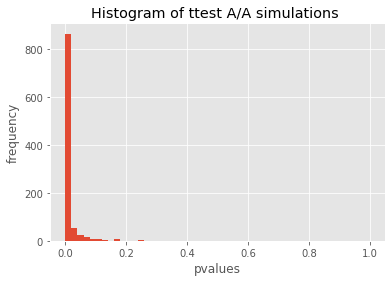

0.93

In [45]:
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df_0.purchase.sample(n_s, replace = False).values
    s2 = df_1.purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

В результате A/A теста FPR > 0.05, что говорит о поломке сплит-системы.

Для нахождения причины, рассмотрим коэффициент покупок по вариантам теста и по версиям приложения:

In [46]:
df.groupby(['experimentVariant','version'],as_index=False)\
.agg({'purchase':'mean'})

,experimentVariant,version,purchase
0,0,v2.8.0,0.000993
1,0,v2.9.0,0.074658
2,0,v3.7.4.0,0.059943
3,0,v3.8.0.0,0.057604
4,1,v2.8.0,0.045606
5,1,v2.9.0,0.071304
6,1,v3.7.4.0,0.063018
7,1,v3.8.0.0,0.062848


Можно заметить, что конверсия для версии приложения v2.8.0 сильно отличается в двух группах. 

Проверим p-value для каждой версии приложения:

In [50]:
pd.DataFrame({'version':['v2.8.0', 'v2.9.0', 'v3.7.4.0', 'v3.8.0.0'], 
              'p-value':[mannwhitneyu(df_0.query('version=="v2.8.0"').purchase,  df_1.query('version=="v2.8.0"').purchase)[1],
              mannwhitneyu(df_0.query('version=="v2.9.0"').purchase,  df_1.query('version=="v2.9.0"').purchase)[1],
              mannwhitneyu(df_0.query('version=="v3.7.4.0"').purchase,  df_1.query('version=="v3.7.4.0"').purchase)[1],
              mannwhitneyu(df_0.query('version=="v3.8.0.0"').purchase,  df_1.query('version=="v3.8.0.0"').purchase)[1]]
             })

,version,p-value
0,v2.8.0,0.000000
1,v2.9.0,0.318300
2,v3.7.4.0,0.556865
3,v3.8.0.0,0.231856


Для версии приложения v2.8.0 p-value < 0.05, значит можно отклонить нулевую гипотезу о том, что различий в группах нет.

Исключим из датафрейма версию v2.8.0 и проведем A/A тест:

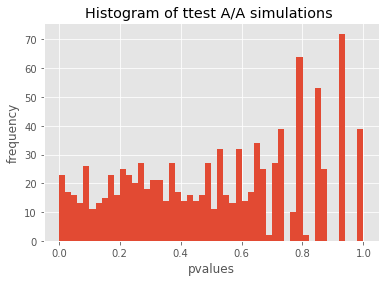

0.046

In [51]:
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df_0.query('version!="v2.8.0"').purchase.sample(n_s, replace = False).values
    s2 = df_1.query('version!="v2.8.0"').purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

В результате, FPR < 0.05. Это позволяет сделать вывод о том, что основная причина поломки сплит-системы заключалась в различии конверсии в группах для версии приложения v2.8.0. 